## Fourier Methods for Option Pricing

We will price a European Put option using 3 methods

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Initialize the relevant parameters

In [2]:
# Share specific information
r = 0.1
S0 = 120
sigma = 0.25
K = 100
T = 2
t = 0 # when the option is priced

### 2. Calculate the analytical price for the put option using the closed-form solution

In [3]:
# analytical price for comparison
def analytic_put_price(r, sigma, S0, K, T, t=0):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)

    phi = stats.norm.cdf
    return -S0*phi(-d1) + K*np.exp(-r*(T-t))*phi(-d2)

analytic_price = analytic_put_price(r, sigma, S0, K, T)
print("Analytical price: {0}".format(analytic_price))

Analytical price: 2.4693867508857075


### 3. Calculate the estimate for the put price using the characteristic function and technique described in note set 1

In [4]:
# Charateristic function of a Normal random variable
def CF(t, mu=0, s=1):
    return np.exp(1j*t*mu - (t**2)*(s**2) / 2)

def c_M1(t):
    return CF(t, mu=np.log(S0) + (r - sigma**2/2)*T, s=sigma*np.sqrt(T))
def c_M2(t):
    return CF(t, mu=np.log(S0) + (r + sigma**2/2)*T, s=sigma*np.sqrt(T))

In [5]:
# choosing t_max (upper limit of the integral) and N (the number of partitions to sum over)
t_max = 40
N = 200

def integrate(f, l, r, N=200):
    # calculating delta and constructing t_n
    delta_t = (r - l) / N
    from_1_to_N = np.linspace(1,N,N)
    t_n = (from_1_to_N - 1/2)*delta_t
    return np.sum(f(t_n)*delta_t)

def I(f):
    return lambda x: (np.exp(-1j*x*np.log(K))*f(x)).imag/x

first_integral = integrate(I(c_M2), 0, t_max, N=N) 
second_integral = integrate(I(c_M1), 0, t_max, N=N)    

In [6]:
fourier_price = -S0*(1/2 - first_integral/np.pi) + np.exp(-r*T)*K*(1/2 - second_integral/np.pi)
print("Fourier transform price: {0}".format(fourier_price))

Fourier transform price: 2.4693867508857164


### 4. Use the COS method to price the European put option. Calculate put prices for increasing upper limits on the COS method sum. Plot your results against the analytical price

In [7]:
# define two intermediate function
def upsilon_n(c, d, n, b1, b2):
    npi = n*np.pi/(b2-b1)
    npi_c = npi * (c - b1)
    npi_d = npi * (d - b1)
    
    numerator = np.cos(npi_d)*np.exp(d) - np.cos(npi_c)*np.exp(c) + npi * (np.sin(npi_d) * np.exp(d) - np.sin(npi_c) * np.exp(c))
    return numerator / (1+ npi**2)

def psi_n(c, d, n, b1, b2):
    if n==0:
        return d-c
    else:
        return (b2 - b1)/(n*np.pi) * (np.sin(n*np.pi*(d - b1)/(b2 - b1)) - np.sin(n*np.pi*(c - b1)/(b2 - b1)))

In [8]:
# intermediate integral
def v_n(n, K, b1, b2):
    return 2/(b2 - b1) * K * (- upsilon_n(b1, 0, n, b1, b2) + psi_n(b1, 0, n, b1, b2))

def fourier_cos_put_price(r, sigma, S0, K, T, N, b1, b2):
    mu = np.log(S0/K) + (r - sigma**2/2)*T
    s = sigma*np.sqrt(T)
    npi = lambda n: n*np.pi/(b2 - b1)
    v = lambda n: v_n(n, K, b1, b2)
    first_term = v(0)*CF(0, mu=mu, s=s)/2
    second_term = np.sum([(CF(npi(n), mu=mu, s=s) * np.exp(-1j*b1*npi(n))).real * v(n) for n in range(1, N)])
    return np.exp(-r*T)*(first_term + second_term).real

In [9]:
# define the cumulants used for calculating b1 and b2
c1 = r
c2 = sigma**2 * T
c4 = 0
L = 10

b1 = c1 - L*np.sqrt(c2 + np.sqrt(c4))
b2 = c1 + L*np.sqrt(c2 + np.sqrt(c4))

In [10]:
def logchar_func(u, S0, r, sigma, K, T):
    return np.exp(1j*u*(np.log(S0/K) + (r-sigma**2/2)*T) - (sigma**2)*T*(u**2)/2)

def put_price(N, S0, sigma, r, K, T, b2, b1):
    price = v_n(0, K, b1, b2) * logchar_func(0, S0, r, sigma, K, T)/2
    for n in range(1, N):
        price += logchar_func(n*np.pi/(b2-b1), S0, r, sigma, K, T) * np.exp(-1j*n*np.pi*b1/(b2-b1)) * v_n(n, K, b1, b2)
    return price.real * np.exp(-r*T)

[]

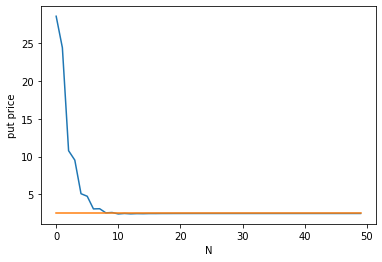

In [11]:
fourier_cos_prices = [fourier_cos_put_price(r, sigma, S0, K, T, n, b1, b2) for n in range (1, 51)]
plt.plot(fourier_cos_prices)
plt.plot([analytic_price] * 50)
plt.xlabel('N')
plt.ylabel('put price')
plt.plot()

In [12]:
print("Fourier COS price: {0}".format(fourier_cos_prices[-1]))

Fourier COS price: 2.469386750885702


### 5. Use the Fast Fourier Transform method to price the European put option

In [54]:
def FFT_price (r, sigma, S0, K, T, N=2**10, delta=0.25, alpha=-2):
    def c_func(v):
        val1 = np.exp(-r*T) * CF(v-(alpha+1)*1j, mu=np.log(S0)+(r-sigma**2/2)*T, s=sigma*np.sqrt(T))
        val2 = alpha**2 + alpha - v**2 + 1j*(2*alpha + 1)*v
        return val1/val2
    
    n = np.array(range(N))
    delta_k = 2*np.pi/(N*delta)
    b = delta_k * (N-1)/2
    
    log_strike = np.linspace(-b, b, N)
    
    x = np.exp(1j*b*n*delta)*c_func(n*delta)*delta
    x[0] = x[0]*0.5
    x[-1] = x[-1]*0.5
    
    x_hat = np.fft.fft(x).real
    fft_put = np.exp(-alpha*log_strike)*x_hat/np.pi
    
    return log_strike, fft_put

In [55]:
log_strike, fft_price = FFT_price(r, sigma, S0, K, T)
analytic_prices = np.array([analytic_put_price(r, sigma, S0, np.exp(log_strike), T)]).reshape(log_strike.shape) # since log_strike is being divided, the output's dimension is flipped

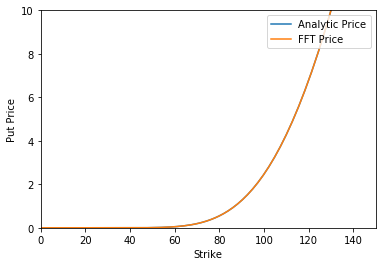

In [56]:
plt.plot(np.exp(log_strike), analytic_prices, label="Analytic Price") #LINE 1
plt.plot(np.exp(log_strike), fft_price, label="FFT Price") #LINE 2
plt.axis([0,150,0,10]) # rescale
plt.xlabel("Strike")
plt.ylabel("Put Price")
plt.legend(loc="upper right")
plt.show() #LINE 4

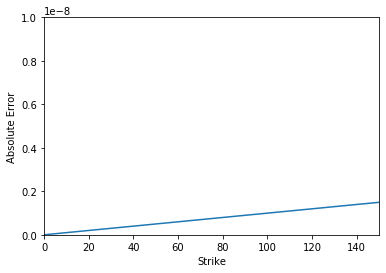

In [60]:
plt.plot(np.exp(log_strike), np.absolute(fft_price - analytic_prices))
plt.axis([0, 150, 0, 0.00000001])
plt.xlabel("Strike")
plt.ylabel("Absolute Error")
plt.show()

In [61]:
K_idx = np.abs(log_strike - np.log(K)).argmin()
print(f"Nearest strike found is: {np.exp(log_strike[K_idx]):.4f}")
print("FFT price at this trike is: {0:.4f}".format(fft_price[K_idx]))
print("Analytical price at this trike is: {0:.4f}".format(analytic_prices[K_idx]))

Nearest strike found is: 99.6777
FFT price at this trike is: 2.4215
Analytical price at this trike is: 2.4215


#### Since $N=2^{10}$ is not refined enough to get as close to the strike price $K = 100$ as we want, I'll try with $N=2^{20}$

In [64]:
log_strike, fft_price = FFT_price(r, sigma, S0, K, T, N=2**20)
analytic_prices = np.array([analytic_put_price(r, sigma, S0, np.exp(log_strike), T)]).reshape(log_strike.shape) # since log_strike is being divided, the output's dimension is flipped
K_idx = np.abs(log_strike - np.log(K)).argmin()
print(f"Nearest strike found is: {np.exp(log_strike[K_idx])}")
print("FFT price at this trike is: {0}".format(fft_price[K_idx]))
print("Analytical price at this trike is: {0}".format(analytic_prices[K_idx]))

Nearest strike found is: 99.9995934176639
FFT price at this trike is: 2.4693258880769022
Analytical price at this trike is: 2.4693258870811974


#### Now, this is good enough !